## ATAC + MULTIOME (females september 2021)

### Label transfer with Seurat 

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.figdir = '/home/jovyan/MULTIOME_july2021/figures_females/'

In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
import rpy2.rinterface_lib.callbacks
import logging

In [5]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [6]:
import anndata2ri
anndata2ri.activate()

In [7]:
%load_ext rpy2.ipython

In [8]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(Seurat)
library(dplyr)
library(data.table)
library(GenomicRanges)
library(EnsDb.Hsapiens.v86)
#library(cicero)
library(Signac)
#library(clustree)
library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)

In [9]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

**Load data**

In [10]:
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/females_july2021/"
experiment_prefix = 'females_'

Try to use the gene accessibility scores computed with Emma's method and integrate with matched scRNAseq samples annotated by Luz 

In [9]:
%%R -i outdir -i experiment_prefix -o ATAC_geneScores
Convert(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"), overwrite = TRUE)
ATAC_geneScores <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"))
ATAC_geneScores
table(ATAC_geneScores@meta.data$individual)

 [1]  8594  1172  3450  4857  1641  8834 21060 10747  5315  7483  4571 12205


In [10]:
%%R -i outdir -i experiment_prefix -o RNAseq
Convert(paste0(outdir, experiment_prefix, "_RNAseq.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"), overwrite = TRUE, verbose = TRUE)

RNAseq <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"))
RNAseq
table(RNAseq@meta.data$donor)

 [1]  7706  1408  1065  1647  2535  7344 20396  2352  2965  9784


In [11]:
%%R -i RNAseq

print(table(RNAseq@meta.data$lineage)) 


          CoelEpi       Endothelial        Epithelial         Erythroid 
             3583              3176              5679               105 
        GermCells            Immune Mesenchymal_GATA2  Mesenchymal_LHX9 
             2474              1008              8000              8000 
           Neural                PV              SMCs        Supporting 
              830              5309              3038              8000 
     preGranulosa 
             8000 


**Try label transfer with major cluster annotations**

In [12]:
%%R -i RNAseq -i ATAC_geneScores -o RNA2ATAC

# Normalize both RNA and ATAC data
RNAseq <- NormalizeData(object = RNAseq, verbose = TRUE)
ATAC_geneScores <- NormalizeData(object = ATAC_geneScores, verbose = TRUE)

# Find HVGs in both RNA and ATAC data
RNAseq  <- FindVariableFeatures(object = RNAseq, selection.method = "vst", nfeatures = 3000, verbose = TRUE)
ATAC_geneScores <- FindVariableFeatures(object = ATAC_geneScores, selection.method = "vst", nfeatures = 3000, verbose = TRUE)

# Find anchors to do integration using RNA as reference and ATAC as query 
transfer_anchors <- FindTransferAnchors(reference = RNAseq, query = ATAC_geneScores, 
    dims = 1:25, reduction = "cca")

# Transfer labels from RNA to ATAC
RNA2ATAC <- TransferData(anchorset = transfer_anchors, refdata = RNAseq@meta.data$lineage, dims = 1:25, weight.reduction = "cca",
                        prediction.assay = TRUE)

# Add metadata to ATAC
#ATAC_geneScores_labels <- AddMetaData(object = ATAC_geneScores, metadata = RNA2ATAC)

In [13]:
%%R -i RNA2ATAC -o predicted_probabilities -i ATAC_geneScores

ATAC_geneScores[['scores']] <- RNA2ATAC
ATAC_geneScores
DefaultAssay(ATAC_geneScores) <- "scores" # Change default assay 
predicted_probabilities <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_geneScores))))

In [14]:
predicted_probabilities

preGranulosa  Mesenchymal-LHX9  Supporting   CoelEpi  \
13-AAACAGCCAAGCGATG-1      0.947281          0.046421    0.002984  0.003314   
13-AAACAGCCACTAGCGT-1      0.994107          0.000000    0.005893  0.000000   
13-AAACAGCCAGCCAGAA-1      0.085486          0.047032    0.000523  0.035394   
13-AAACAGCCATCCAGGT-1      0.000000          0.000000    0.000000  0.000000   
13-AAACATGCATCCCGCT-1      0.976623          0.000000    0.000000  0.023377   
...                             ...               ...         ...       ...   
12-TTTGTGTCACGCGACT-1      0.000000          0.000000    0.000000  0.000000   
12-TTTGTGTCATTCCCGT-1      0.000000          0.000000    0.000000  0.000000   
12-TTTGTGTGTGCTGAAG-1      1.000000          0.000000    0.000000  0.000000   
12-TTTGTGTGTTAACCGT-1      1.000000          0.000000    0.000000  0.000000   
12-TTTGTGTGTTAAGTCC-1      0.004415          0.001898    0.002603  0.000613   

                       Endothelial  Mesenchymal-GATA2   PV  GermCells  \
13-AAACAGCCAAGCGATG-1     0.000000                0.0  0.0   0.000000   
13-AAACAGCCACTAGCGT-1     0.000000                0.0  0.0   0.000000   
13-AAACAGCCAGCCAGAA-1     0.000000                0.0  0.0   0.831565   
13-AAACAGCCATCCAGGT-1     0.000000                0.0  0.0   1.000000   
13-AAACATGCATCCCGCT-1     0.000000                0.0  0.0   0.000000   
...                            ...                ...  ...        ...   
12-TTTGTGTCACGCGACT-1     0.000000                0.0  0.0   0.000000   
12-TTTGTGTCATTCCCGT-1     0.000000                0.0  0.0   0.000000   
12-TTTGTGTGTGCTGAAG-1     0.000000                0.0  0.0   0.000000   
12-TTTGTGTGTTAACCGT-1     0.000000                0.0  0.0   0.000000   
12-TTTGTGTGTTAAGTCC-1     0.000571                0.0  0.0   0.000000   

                       Epithelial  Immune  Neural  SMCs  Erythroid       max  
13-AAACAGCCAAGCGATG-1         0.0  0.0000     0.0   0.0        0.0  0.947281  
13-AAACAGCCACTAGCGT-1         0.0  0.0000     0.0   0.0        0.0  0.994107  
13-AAACAGCCAGCCAGAA-1         0.0  0.0000     0.0   0.0        0.0  0.831565  
13-AAACAGCCATCCAGGT-1         0.0  0.0000     0.0   0.0        0.0  1.000000  
13-AAACATGCATCCCGCT-1         0.0  0.0000     0.0   0.0        0.0  0.976623  
...                           ...     ...     ...   ...        ...       ...  
12-TTTGTGTCACGCGACT-1         1.0  0.0000     0.0   0.0        0.0  1.000000  
12-TTTGTGTCATTCCCGT-1         0.0  0.0000     0.0   1.0        0.0  1.000000  
12-TTTGTGTGTGCTGAAG-1         0.0  0.0000     0.0   0.0        0.0  1.000000  
12-TTTGTGTGTTAACCGT-1         0.0  0.0000     0.0   0.0        0.0  1.000000  
12-TTTGTGTGTTAAGTCC-1         0.0  0.9899     0.0   0.0        0.0  0.989900  

[89929 rows x 14 columns]

In [15]:
predicted_probabilities.columns

Index(['preGranulosa', 'Mesenchymal-LHX9', 'Supporting', 'CoelEpi',
       'Endothelial', 'Mesenchymal-GATA2', 'PV', 'GermCells', 'Epithelial',
       'Immune', 'Neural', 'SMCs', 'Erythroid', 'max'],
      dtype='object')

Replace dashes with underscores as stupid R changes them

In [16]:
predicted_probabilities.columns = ['preGranulosa', 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi',
       'Endothelial', 'Mesenchymal_GATA2', 'PV', 'GermCells', 'Epithelial',
       'Immune', 'Neural', 'SMCs', 'Erythroid', 'max']

**Save the predicted annotations to the gene activity anndata object for ATAC**

In [17]:
gene_data = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")
gene_data

AnnData object with n_obs × n_vars = 89929 × 16882
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi', 'Endothelial', 'PV', 'Mesenchymal_GATA2', 'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid', 'max', 'mean_gene_activity'
    var: 'gene_id'
    uns: 'individual_colors', 'neighbors', 'sample_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_46', 'X_umap'
    obsp: 'connectivities', 'distances'

In [18]:
gene_data.obs = gene_data.obs.drop([ 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi', 'Endothelial', 'PV', 'Mesenchymal_GATA2', 'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid', 'max', 'mean_gene_activity'], axis = 1)

In [19]:
for pred in predicted_probabilities.columns: 
    print(pred)
    gene_data.obs[pred] = predicted_probabilities[pred]

preGranulosa
Mesenchymal_LHX9
Supporting
CoelEpi
Endothelial
Mesenchymal_GATA2
PV
GermCells
Epithelial
Immune
Neural
SMCs
Erythroid
max


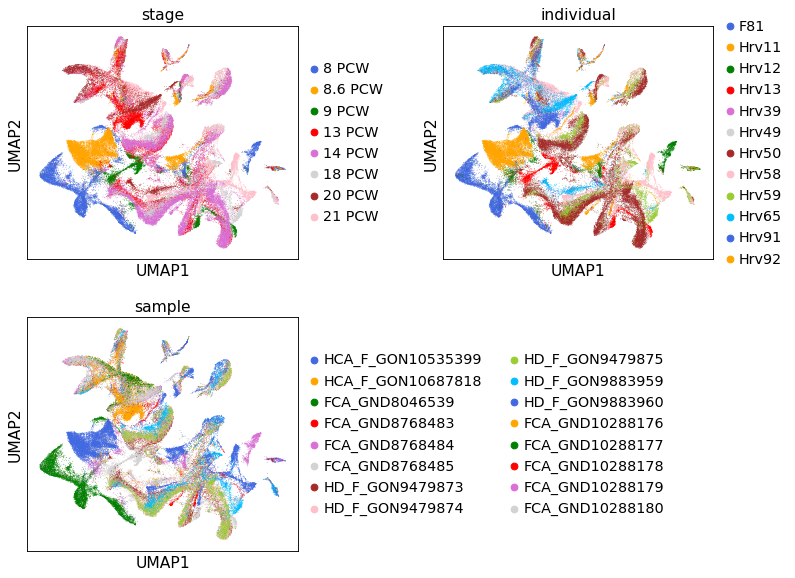

In [21]:
sc.pl.umap(gene_data, color = ['stage', 'individual', 'sample'], ncols = 2, wspace = 0.4, 
            save = "_noharmony.pdf")

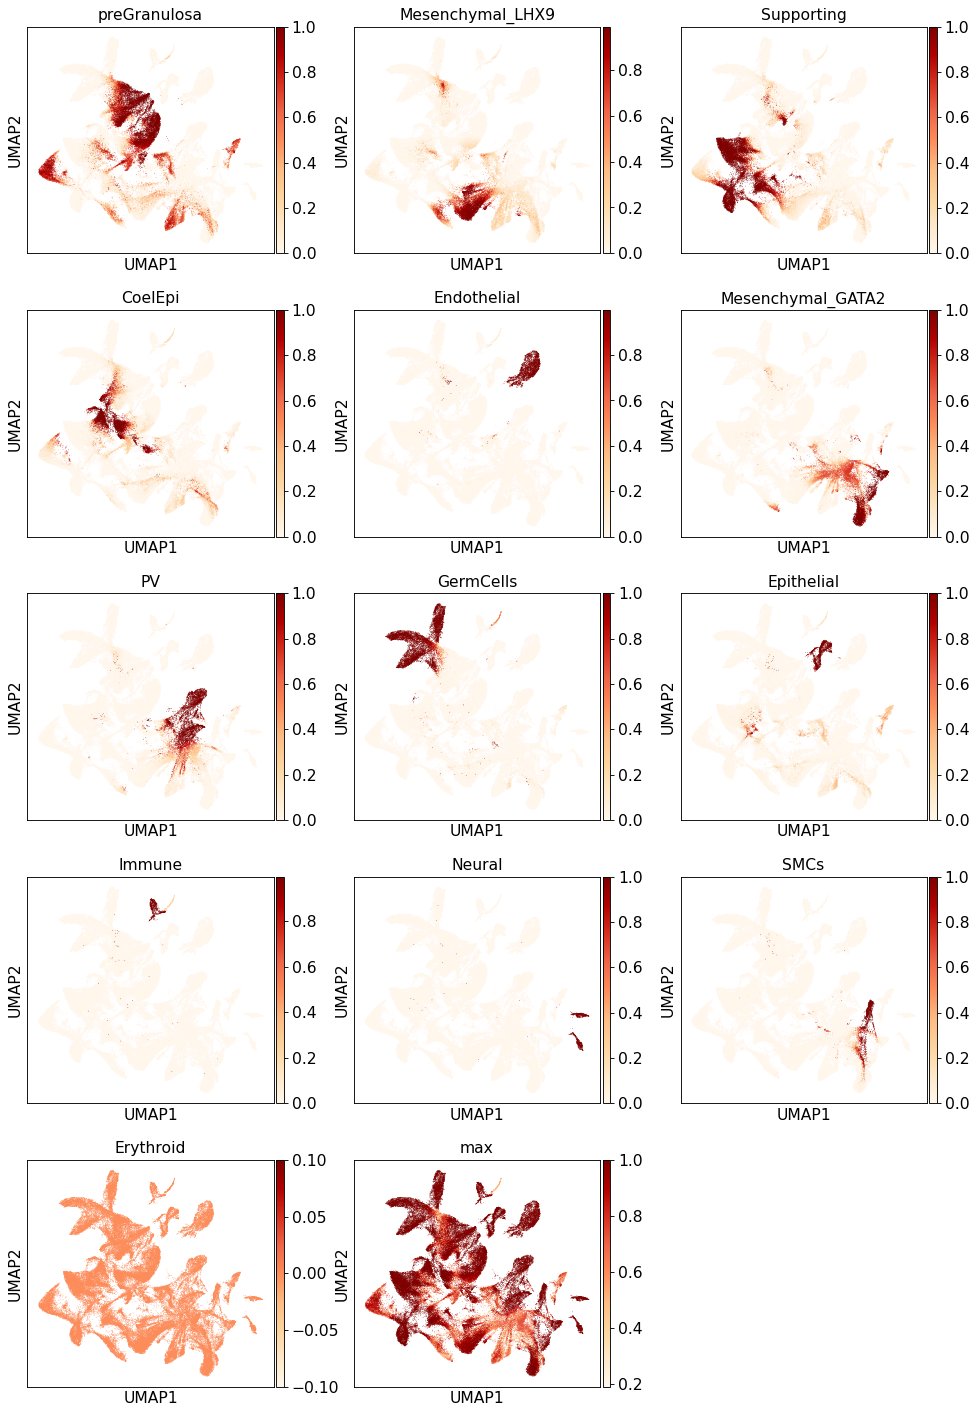

In [42]:
sc.pl.umap(gene_data, color = ['preGranulosa', 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi',
       'Endothelial', 'Mesenchymal_GATA2', 'PV', 'GermCells', 'Epithelial',
       'Immune', 'Neural', 'SMCs', 'Erythroid', 'max'], ncols = 3, color_map = 'OrRd', save = "_probs_noharmony.pdf")

#### Look at average gene activity scores to identify cycling population

This was suggested by Luz 

In [24]:
gene_data.X

array([[37., 29., 29., ..., 31., 23., 48.],
       [42., 31., 31., ..., 29., 26., 41.],
       [30., 45., 45., ..., 29., 28., 67.],
       ...,
       [52., 29., 29., ..., 30., 33., 75.],
       [51., 27., 27., ..., 31., 32., 68.],
       [88., 48., 48., ..., 32., 28., 33.]], dtype=float32)

In [25]:
mean_by_cell = gene_data.X.mean(axis=1)
mean_by_cell

array([57.889824, 58.294456, 57.41251 , ..., 58.564686, 57.812286,
       64.4532  ], dtype=float32)

In [26]:
means = pd.DataFrame(mean_by_cell, columns=['mean_gene_activity'], index=gene_data.obs_names)
means.head()

mean_gene_activity
13-AAACAGCCAAGCGATG-1           57.889824
13-AAACAGCCACTAGCGT-1           58.294456
13-AAACAGCCAGCCAGAA-1           57.412510
13-AAACAGCCATCCAGGT-1           60.431820
13-AAACATGCATCCCGCT-1           58.209751

In [27]:
gene_data.obs['mean_gene_activity'] = means

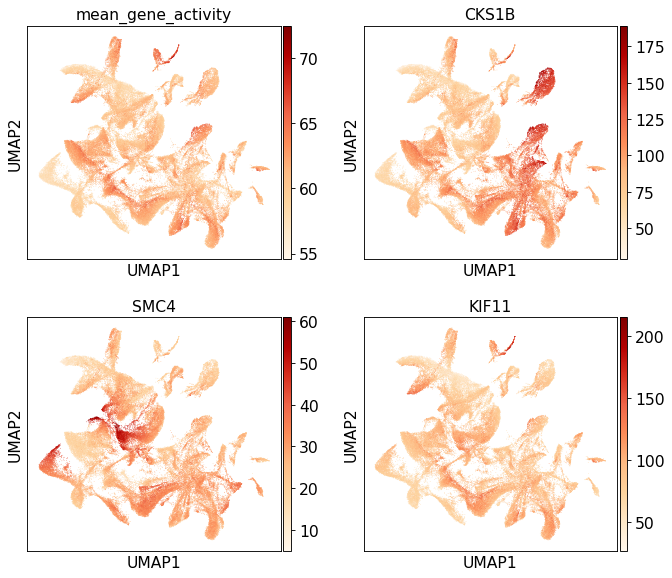

In [28]:
sc.pl.umap(gene_data, color = ['mean_gene_activity', 'CKS1B', 'SMC4', 'KIF11'], ncols = 2, color_map = "OrRd")

In [29]:
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in gene_data.var_names]
print(s_genes)
g2m_genes = [x for x in g2m_genes if x in gene_data.var_names]
print(g2m_genes)

['MCM5', 'UNG', 'GINS2', 'MCM6', 'DTL', 'UHRF1', 'RFC2', 'NASP', 'WDR76', 'SLBP', 'POLD3', 'MSH2', 'ATAD2', 'RRM2', 'CDC6', 'EXO1', 'BLM', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
['BIRC5', 'TPX2', 'TOP2A', 'NUF2', 'CKS1B', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'KIF11', 'GTSE1', 'HJURP', 'RANGAP1', 'CDCA8', 'ECT2', 'KIF23', 'ANLN', 'LBR', 'CTCF', 'NEK2', 'CBX5', 'CENPA']


In [30]:
#sc.pl.umap(gene_data, color = s_genes, color_map = "OrRd")

In [31]:
#sc.pl.umap(gene_data, color = g2m_genes, color_map = "OrRd")

In [32]:
gene_data.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [33]:
gene_data

AnnData object with n_obs × n_vars = 89929 × 16882
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'preGranulosa', 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi', 'Endothelial', 'Mesenchymal_GATA2', 'PV', 'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid', 'max', 'mean_gene_activity'
    var: 'gene_id'
    uns: 'individual_colors', 'neighbors', 'sample_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_46', 'X_umap'
    obsp: 'connectivities', 'distances'

**Save the predicted annotations to the peaks anndata object for ATAC**

In [34]:
adata = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 89929 × 153356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi', 'Endothelial', 'PV', 'Mesenchymal_GATA2', 'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'multiome_GermCells_colors', 'multiome_Somatic_colors', 'neighbors', 'sample_col

In [36]:
adata.obs = adata.obs.drop([ 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi', 'Endothelial', 'PV', 'Mesenchymal_GATA2', 'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid', 'max'
                           ], axis = 1)

In [37]:
for pred in predicted_probabilities.columns: 
    print(pred)
    adata.obs[pred] = predicted_probabilities[pred]

preGranulosa
Mesenchymal_LHX9
Supporting
CoelEpi
Endothelial
Mesenchymal_GATA2
PV
GermCells
Epithelial
Immune
Neural
SMCs
Erythroid
max


In [38]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

In [39]:
adata.obs['multiome_GermCells'].value_counts()

nan                84437
oogonia_STRA8       2131
PGC                 1445
oogonia_meiotic     1142
preOocyte            298
Doublet              230
oocyte               158
lowQC                 88
Name: multiome_GermCells, dtype: int64

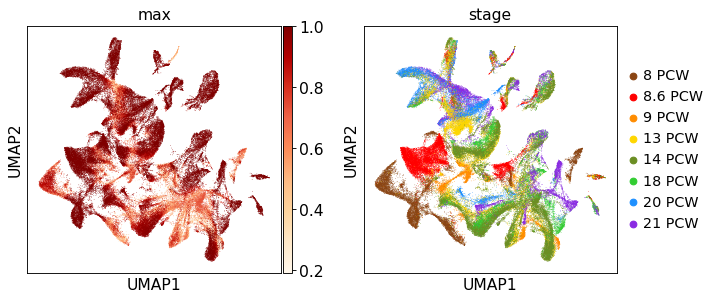

In [40]:
sc.pl.umap(adata, color = ['max', 'stage'], color_map = 'OrRd')

### Harmony integration

In [43]:
adata

AnnData object with n_obs × n_vars = 89929 × 153356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'preGranulosa', 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi', 'Endothelial', 'Mesenchymal_GATA2', 'PV', 'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'multiome_GermCells_colors', 'multiome_Somatic_colors', 'neighbo

In [44]:
# Extract PCA matrix and batch array
n_pcs = 46
pca = adata.obsm['X_cistopic_46'][:, 0:(n_pcs)]
batch = adata.obs['individual']

In [45]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1000)
hem <- HarmonyMatrix(pca, batch, theta=0, do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

In [46]:
# Add harmony values to the anndata object
adata.obsm['X_harmony'] = hem.values

In [47]:
sc.pp.neighbors(adata, use_rep= 'X_harmony', random_state=1234)

In [48]:
sc.tl.umap(adata,  min_dist = 0.5, spread = 1)

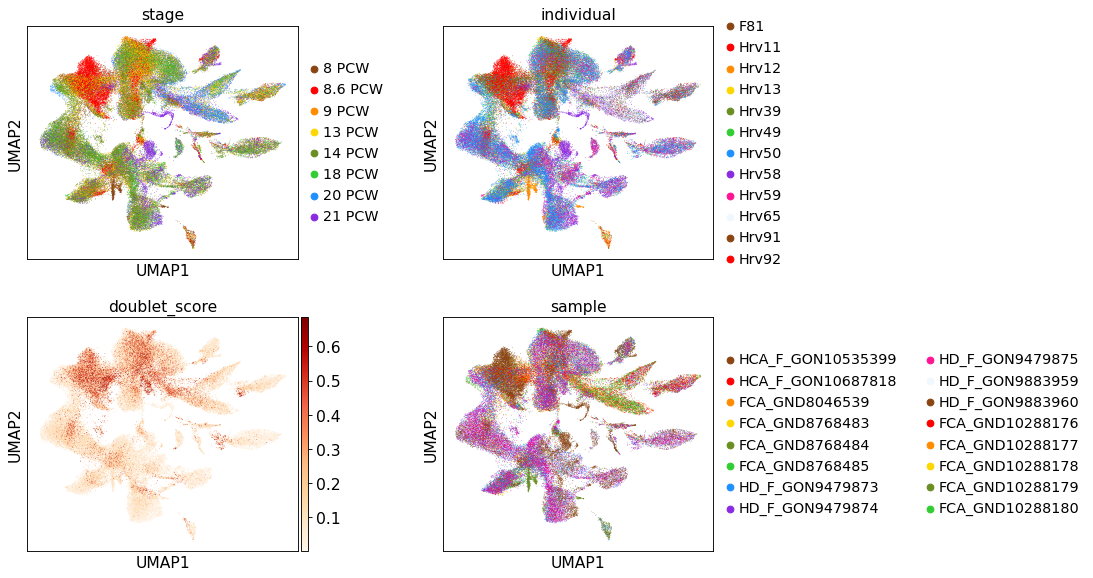

In [49]:
sc.pl.umap(adata, color = ['stage', 'individual', 'doublet_score', 'sample'], ncols = 2, wspace = 0.4, 
            save = "metadata.pdf", color_map = 'OrRd')

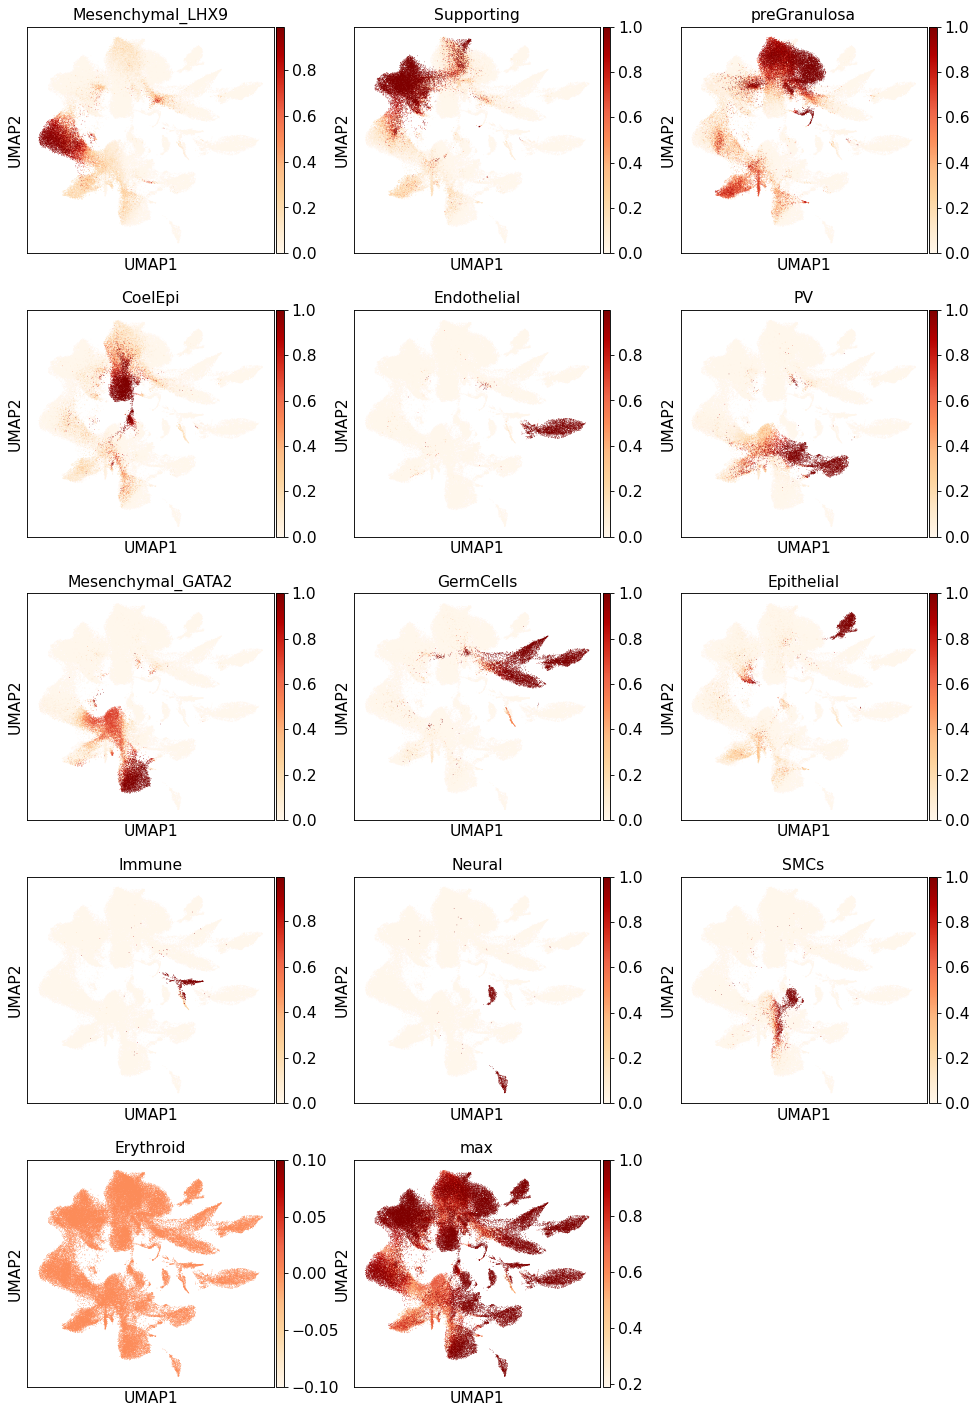

In [50]:
sc.pl.umap(adata, color = ['Mesenchymal_LHX9', 'Supporting', 'preGranulosa', 'CoelEpi', 'Endothelial', 'PV', 'Mesenchymal_GATA2', 'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid', 'max'],
           ncols = 3, color_map = 'OrRd', save = "_probs_harmony.pdf")

#### Visualize position in the manifold of dual ATAC samples

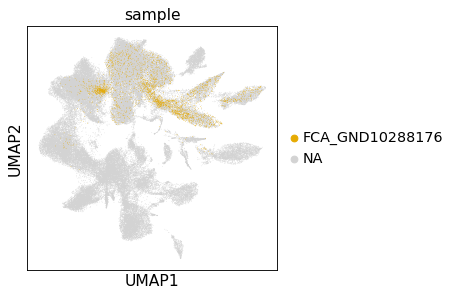

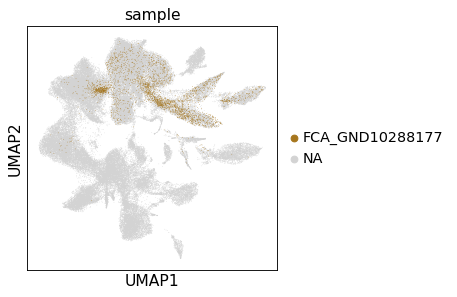

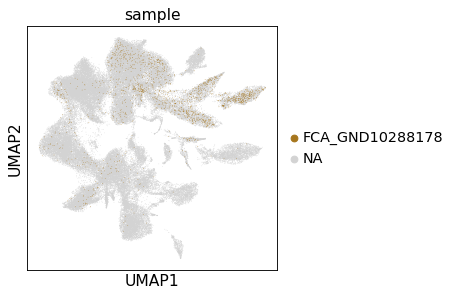

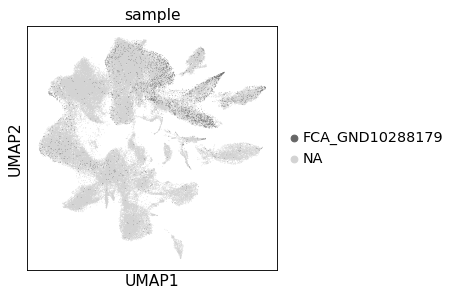

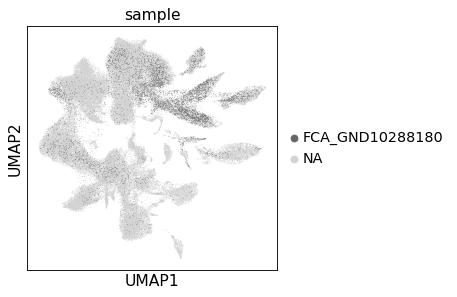

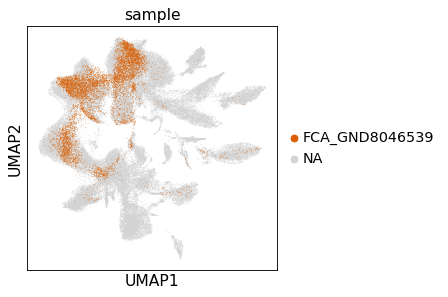

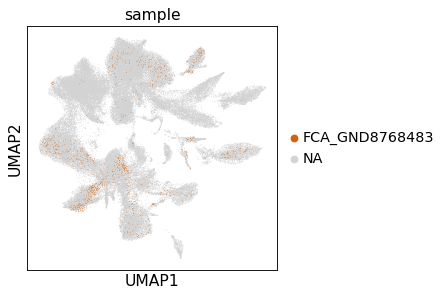

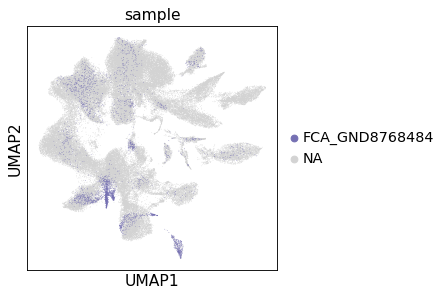

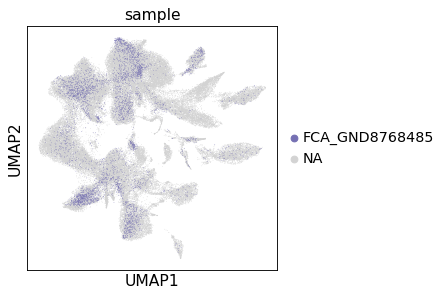

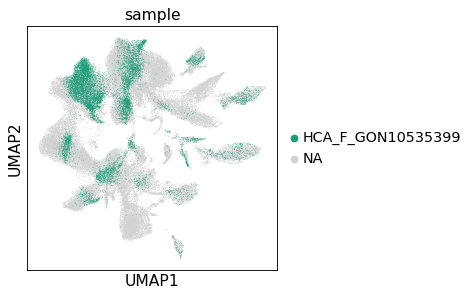

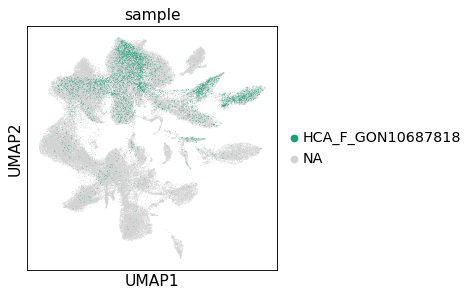

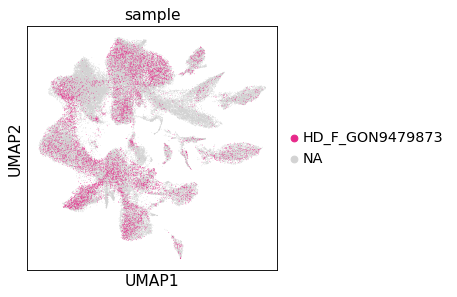

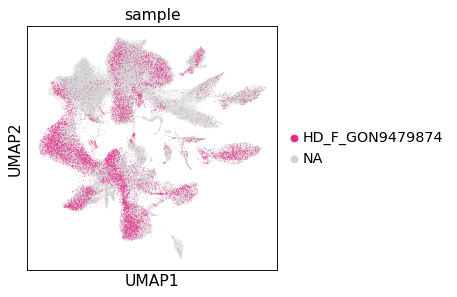

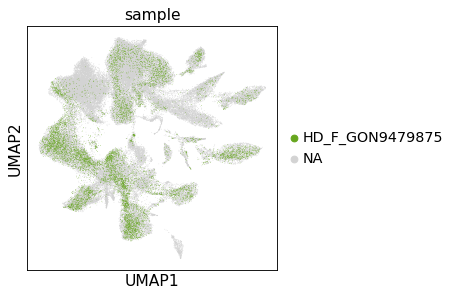

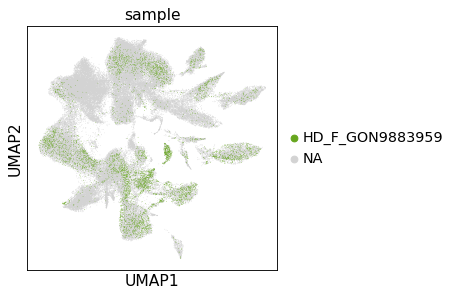

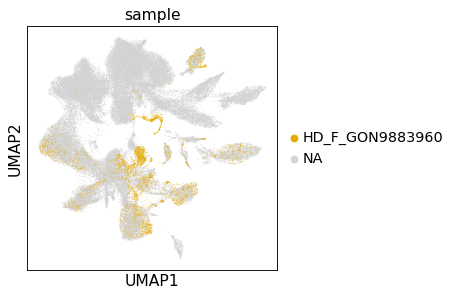

In [51]:
for sample in np.unique(adata.obs['sample']):
    sc.pl.umap(adata, color = 'sample', groups = sample, palette = 'Dark2', save = sample + ".pdf")

In [52]:
adata.write(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")

In [53]:
adata = sc.read(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")

#### Clustering

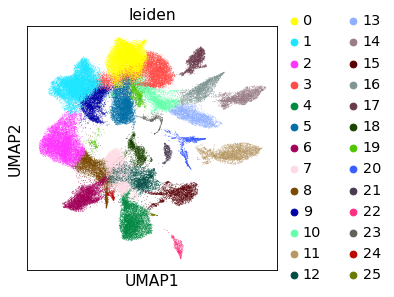

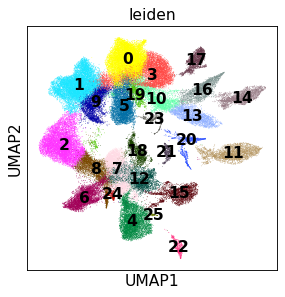

In [54]:
sc.tl.leiden(adata, resolution= 1, random_state = 1234)
sc.pl.umap(adata, color='leiden',save='_clustering.pdf')
sc.pl.umap(adata, color='leiden',legend_loc='on data',save='_clustering_clusnumbers.pdf')

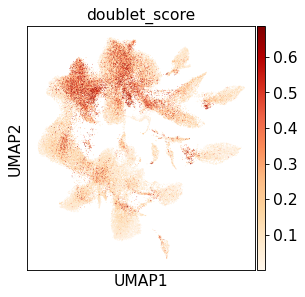

In [55]:
sc.pl.umap(adata, color = ['doublet_score'], color_map = 'OrRd')

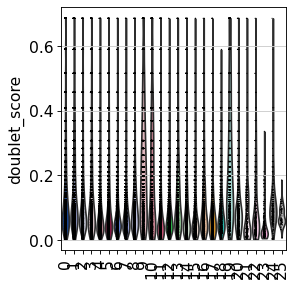

In [56]:
sc.pl.violin(adata, keys = ['doublet_score'], groupby = 'leiden', rotation = 90)

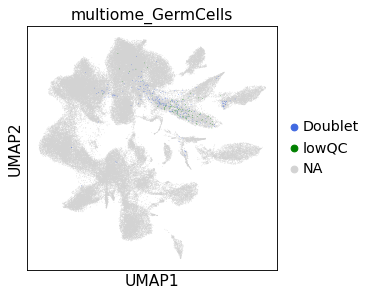

In [57]:
sc.pl.umap(adata, color = ['multiome_GermCells'], groups = ['Doublet', 'lowQC'])

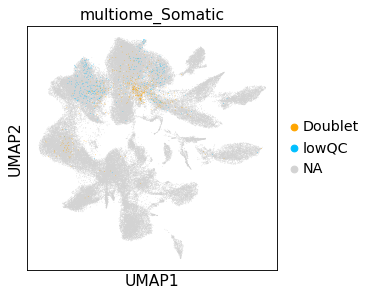

In [58]:
sc.pl.umap(adata, color = ['multiome_Somatic'], groups = ['Doublet', 'lowQC'])

In [59]:
adata

AnnData object with n_obs × n_vars = 89929 × 153356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'preGranulosa', 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi', 'Endothelial', 'Mesenchymal_GATA2', 'PV', 'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'multiome_GermCells_colors', 'multiome_Somatic_colors', 'neighbo

In [60]:
adata[[i in ['19'] for i in adata.obs['leiden']]].obs['multiome_Somatic'].value_counts()

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


nan                 986
Doublet             136
CoelEpi_LHX9         10
preGC_IIa             9
preGC_IIb             9
OSE_cycling           7
Mesenchymal_LHX9      4
preGC_I               4
early_sPAX8           2
granulosa             2
lowQC                 2
Name: multiome_Somatic, dtype: int64

In [61]:
#### Remove cluster 19 of doublets 
adata = adata[[i not in ['19'] for i in adata.obs['leiden']]]
adata.shape

(88758, 153356)

Trying to set attribute `.obs` of view, copying.


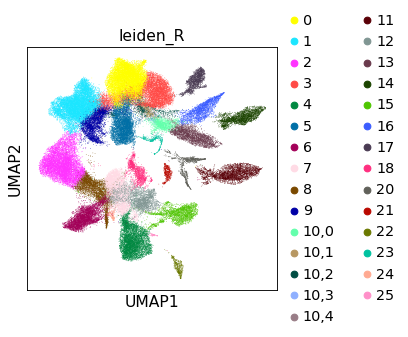

In [62]:
sc.tl.leiden(adata, resolution = 0.3, restrict_to = ('leiden', ['10']))
sc.pl.umap(adata, color = 'leiden_R')

In [63]:
adata[[i in ['10,0'] for i in adata.obs['leiden_R']]].obs['multiome_GermCells'].value_counts()

nan                1371
oogonia_STRA8       106
PGC                  76
Doublet              47
oogonia_meiotic      43
lowQC                19
oocyte               15
preOocyte            10
Name: multiome_GermCells, dtype: int64

In [64]:
# Remove subclusters of doublets 
adata = adata[[i not in ['10,1', '10,2', '10,4'] for i in adata.obs['leiden_R']]]

In [65]:
adata.shape

(87211, 153356)

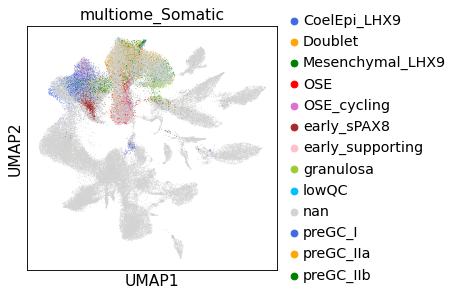

In [66]:
sc.pl.umap(adata, color = ['multiome_Somatic'])

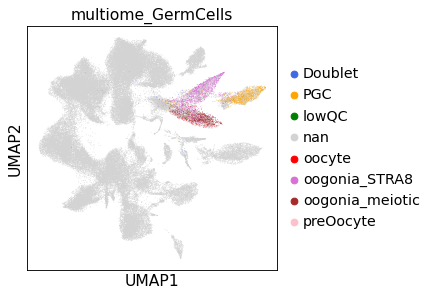

In [67]:
sc.pl.umap(adata, color = ['multiome_GermCells'])

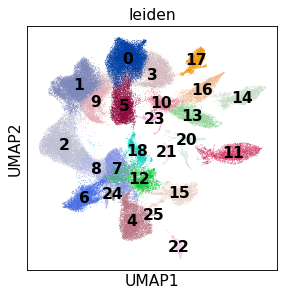

In [108]:
sc.pl.umap(adata, color='leiden',save='_clustering.pdf', legend_loc = 'on data')

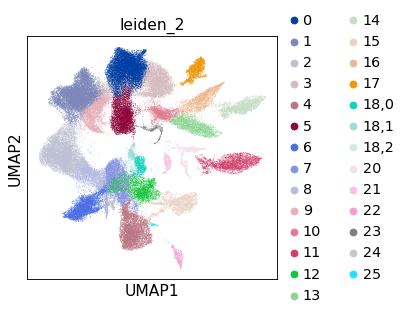

In [71]:
sc.tl.leiden(adata, resolution = 0.2, restrict_to = ('leiden', ['18']), key_added = 'leiden_2')
sc.pl.umap(adata, color = 'leiden_2')

In [72]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

In [73]:
adata = sc.read(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

#### Matrixplot of label transfer predictions vs leiden clusters

In [109]:
adata.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic',
       'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score',
       'doublet_score_0.75', 'leiden', 'preGranulosa', 'Mesenchymal_LHX9',
       'Supporting', 'CoelEpi', 'Endothelial', 'Mesenchymal_GATA2', 'PV',
       'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid',
       'max', 'leiden_R', 'leiden_2', 'cell_type'],
      dtype='object')

In [110]:
obs = adata.obs[[ 'preGranulosa', 'Mesenchymal_LHX9',
       'Supporting', 'CoelEpi', 'Endothelial', 'Mesenchymal_GATA2', 'PV',
       'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid',
       ]]

In [111]:
matrix = obs[[ 'preGranulosa', 'Mesenchymal_LHX9',
       'Supporting', 'CoelEpi', 'Endothelial', 'Mesenchymal_GATA2', 'PV',
       'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid',
       ]].values
matrix.shape

(87211, 13)

In [113]:
plotting_obs = adata.obs[['leiden', 'leiden_2', 'cell_type']]
plotting_obs.shape

(87211, 3)

In [114]:
plotting_probs = [ 'preGranulosa', 'Mesenchymal_LHX9',
       'Supporting', 'CoelEpi', 'Endothelial', 'Mesenchymal_GATA2', 'PV',
       'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid',
       ]
plotting_var_dict = {'probs' : plotting_probs, 'random_string' : [str(i) for i in range(13)]}
plotting_var = pd.DataFrame(plotting_var_dict)
plotting_var = plotting_var.set_index('probs')
plotting_var.head()
plotting_var.shape

(13, 1)

In [115]:
plotting_adata = anndata.AnnData(X = matrix, obs = plotting_obs, var = plotting_var)
plotting_adata

AnnData object with n_obs × n_vars = 87211 × 13
    obs: 'leiden', 'leiden_2', 'cell_type'
    var: 'random_string'

In [116]:
ordered_probs = [ 'preGranulosa', 'Mesenchymal_LHX9',
       'Supporting', 'CoelEpi', 'Endothelial', 'Mesenchymal_GATA2', 'PV',
       'GermCells', 'Epithelial', 'Immune', 'Neural', 'SMCs', 'Erythroid',]

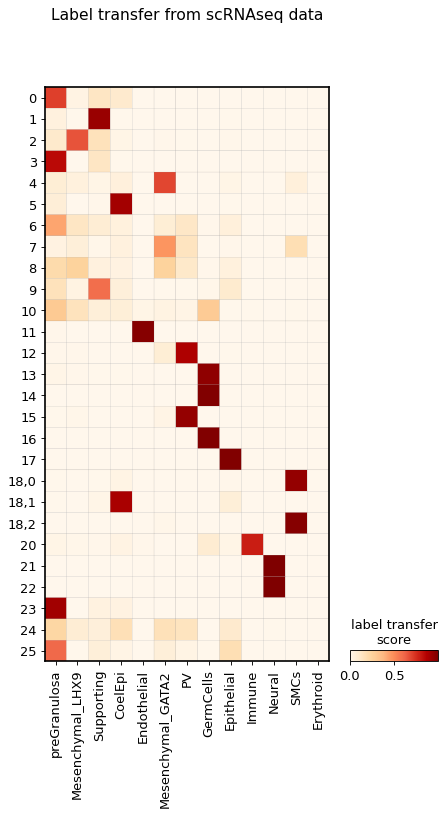

In [117]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'leiden_2', cmap = 'OrRd',
                  save = '_leiden.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

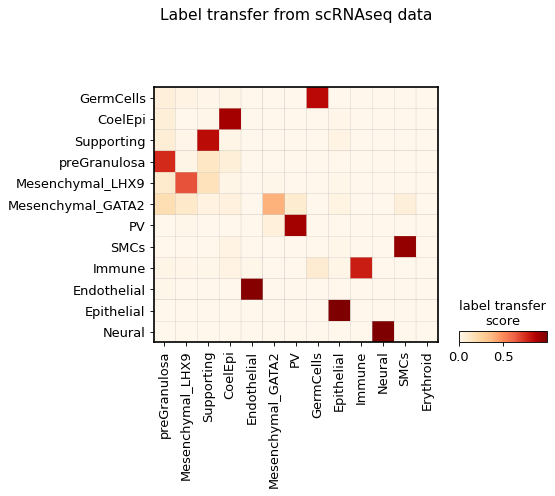

In [118]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_matrixplot.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

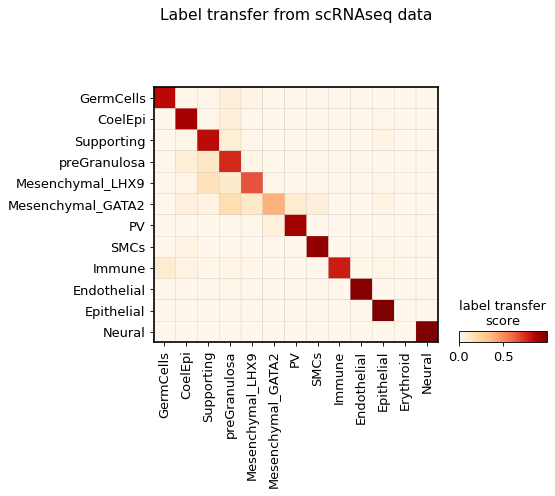

In [119]:
ordered_probs_present = ['GermCells','CoelEpi', 'Supporting', 'preGranulosa', 'Mesenchymal_LHX9', 'Mesenchymal_GATA2', 
                         'PV', 'SMCs',
                 'Immune', 'Endothelial','Epithelial',  'Erythroid','Neural']
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs_present, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_matrixplot_present.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

#### Annotate cells based on label transfer + dual RNA annotations

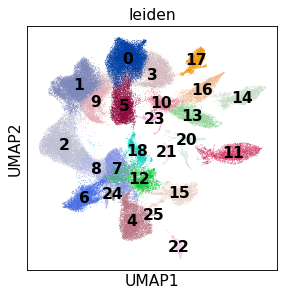

In [91]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

In [93]:
cell_type = {'0' : 'preGranulosa', '3' : 'preGranulosa', '23' : 'preGranulosa', '9' : 'Supporting', '1' : 'Supporting', 
             '2' : 'Mesenchymal_LHX9', '5' : 'CoelEpi', '18,1' : 'CoelEpi', '11' : 'Endothelial', '12' : 'PV', '15' : "PV", '24' : 'Mesenchymal_GATA2',
             '25' : 'Mesenchymal_GATA2', '7' : 'Mesenchymal_GATA2', '8' : 'Mesenchymal_GATA2',
             '6' : 'Mesenchymal_GATA2', '4' : 'Mesenchymal_GATA2', '13' : 'GermCells', '14' : 'GermCells', '16' : 'GermCells',
            '10' : 'GermCells', '17' : 'Epithelial', '20' : 'Immune', '21' : 'Neural', '22' : 'Neural', '18,0' : 'SMCs', '18,2' : 'SMCs'
            }
adata.obs['cell_type'] = adata.obs['leiden_2'].map(cell_type)
adata.obs['cell_type'].value_counts(dropna = False)

Mesenchymal_GATA2    18408
preGranulosa         17405
Supporting           13892
GermCells             9496
Mesenchymal_LHX9      8824
CoelEpi               5691
PV                    5589
Endothelial           3107
Epithelial            1801
Immune                1069
SMCs                   966
Neural                 963
Name: cell_type, dtype: int64

In [94]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories([
   'GermCells', 'CoelEpi',
     'Supporting', 'preGranulosa', 'Mesenchymal_LHX9', 'Mesenchymal_GATA2', 'PV', 'SMCs', 'Immune',  'Endothelial', 
   'Epithelial', 'Neural'
])

In [25]:
female_colors = {'GermCells' : '#e69429', 'CoelEpi' : '#378b4e', 'Supporting' : '#8f72e0',  'preGranulosa' :'#ffb3cd',
            'Mesenchymal_LHX9' : '#dacef4', 'Mesenchymal_GATA2' : '#fbbc04', 
               'PV' : '#d4b16c', 'SMCs' : '#daed3e', 'Immune' : '#039eaa',  'Endothelial' : '#efd6bb', 'Epithelial' : '#b4b90e', 
                'Neural' : '#ffde00'}

adata.uns['lineage_colors'] = female_colors

Trying to set attribute `.uns` of view, copying.


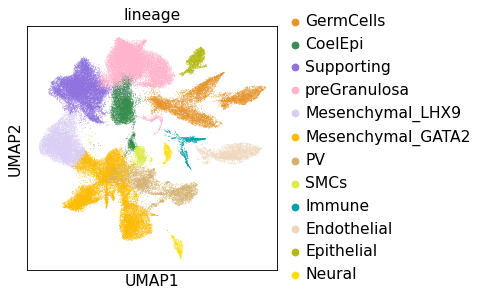

In [12]:
sc.pl.umap(adata, color = 'cell_type', palette = adata.uns['lineage_colors'], 
           legend_fontsize = "medium", legend_fontweight = "medium", frameon = True, 
           title = "lineage",
           save = "_annotations_females.pdf", )

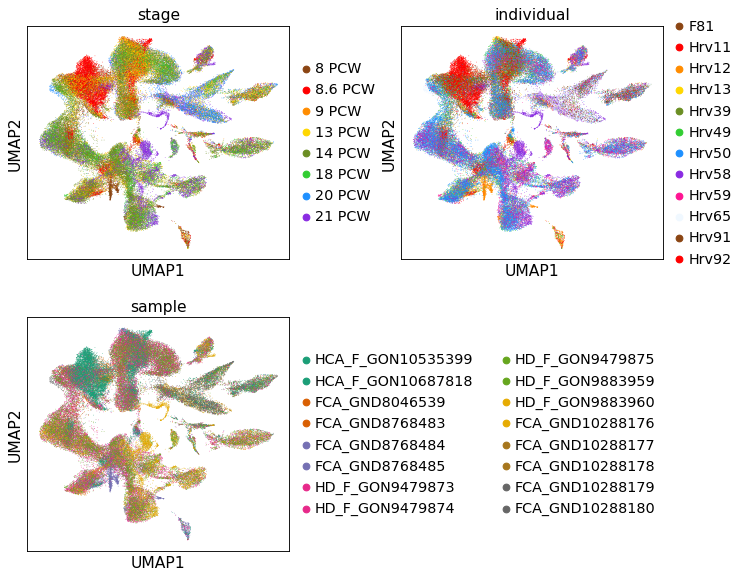

In [121]:
sc.pl.umap(adata, color = ['stage', 'individual', 'sample'], ncols = 2, wspace = 0.3,
          save = '_metadata')

In [99]:
adata.write(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")

In [11]:
adata = sc.read(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")

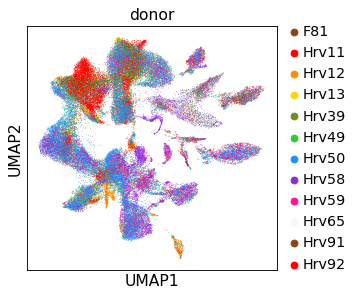

In [13]:
sc.pl.umap(adata, color = 'individual', title = 'donor', save = '_donor')

In [17]:
adata.obs['stage'].value_counts()

14 PCW     22927
13 PCW     12376
8 PCW      11747
8.6 PCW    11214
21 PCW      9601
20 PCW      6761
18 PCW      5245
9 PCW       4760
Name: stage, dtype: int64

In [18]:
stage_numeric = {'14 PCW' : 14, '13 PCW' : 13, '8 PCW' : 8, '8.6 PCW' : 8.6, '21 PCW' : 21, '20 PCW' : 20, 
                '18 PCW' : 18, '9 PCW' : 9}
adata.obs['stage_numeric'] = adata.obs.stage.map(stage_numeric)

In [19]:
adata.obs['stage_numeric'].value_counts(dropna = False)

14.0    22927
13.0    12376
8.0     11747
8.6     11214
21.0     9601
20.0     6761
18.0     5245
9.0      4760
Name: stage_numeric, dtype: int64

In [22]:
adata.obs['stage_numeric'] = adata.obs['stage_numeric'].astype(float)

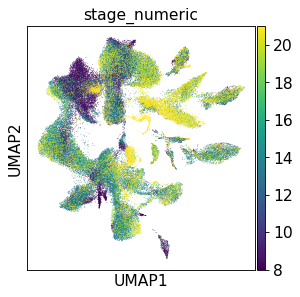

In [23]:
sc.pl.umap(adata, color = 'stage_numeric', color_map = 'viridis', save = '_stage_numeric')

In [24]:
adata.obs['multiome_GermCells'] = np.where(adata.obs['multiome_GermCells'] == 'preOocyte', 'pre_oocyte', adata.obs['multiome_GermCells'])

In [25]:
adata.obs['multiome_GermCells'] = adata.obs['multiome_GermCells'].astype('category')
adata.obs['multiome_GermCells'] = adata.obs['multiome_GermCells'].cat.reorder_categories(['PGC', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_oocyte', 'oocyte', 
                                                                                         'lowQC', 'Doublet', 'nan'])

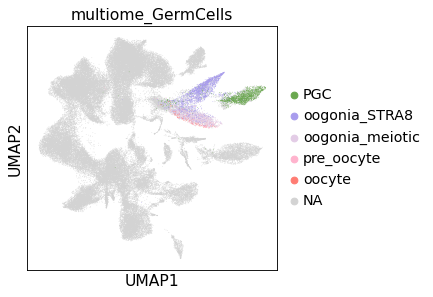

In [26]:
sc.pl.umap(adata, color = 'multiome_GermCells', save = '_multiome_Germcells', palette = ['#6aa84f', '#a89ced', '#e3cce6', '#ffb3cd', '#ff7c73', '#f3f3f3'],
          groups = ['PGC', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_oocyte', 'oocyte'])

In [27]:
adata.obs['multiome_Somatic'] = np.where(adata.obs['multiome_Somatic'] == 'early_sPAX8', 'sPAX8', adata.obs['multiome_Somatic'])

In [28]:
adata.obs['multiome_Somatic'] = np.where(adata.obs['multiome_Somatic'] == 'OSE_cycling', 'OSE', adata.obs['multiome_Somatic'])

In [29]:
adata.obs['multiome_Somatic'] = adata.obs['multiome_Somatic'].astype('category')
adata.obs['multiome_Somatic'] = adata.obs['multiome_Somatic'].cat.reorder_categories(['CoelEpi_LHX9', 'early_supporting', 'sPAX8', 'preGC_I', 'OSE', 
                                                                                     'preGC_IIa', 'preGC_IIb', 'granulosa', 'Mesenchymal_LHX9', 'lowQC', 
                                                                                     'nan', 'Doublet'])

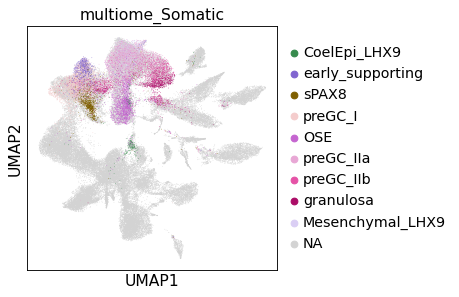

In [30]:
sc.pl.umap(adata, color = 'multiome_Somatic', palette = ['#378b4e', '#8165d0', '#7f6000', '#f4cccc', '#c565d0', '#e8a7d5', '#e552a6', '#ab0c67', '#dacef4'], 
          groups = ['CoelEpi_LHX9', 'early_supporting', 'sPAX8', 'preGC_I', 'OSE', 
                                                                                     'preGC_IIa', 'preGC_IIb', 'granulosa', 'Mesenchymal_LHX9'], 
          save = '_multiome_Somatic')

In [32]:
adata.obs['multiome_Somatic'] = np.where(adata.obs['multiome_Somatic'] == 'nan', adata.obs['multiome_GermCells'],
                                        adata.obs['multiome_Somatic'])

In [33]:
adata.obs['multiome_Somatic'].value_counts(dropna = False)

nan                 65825
preGC_I              2892
preGC_IIa            2733
oogonia_STRA8        2112
OSE                  1792
preGC_IIb            1728
PGC                  1434
oogonia_meiotic      1138
sPAX8                1046
early_supporting     1011
granulosa             971
Mesenchymal_LHX9      902
pre_oocyte            296
CoelEpi_LHX9          270
Doublet               209
oocyte                157
lowQC                 115
Name: multiome_Somatic, dtype: int64

In [38]:
adata.obs['multiome_Somatic'] = adata.obs['multiome_Somatic'].astype('category')
adata.obs['multiome_Somatic'] = adata.obs['multiome_Somatic'].cat.reorder_categories(['PGC', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_oocyte', 'oocyte','CoelEpi_LHX9', 'early_supporting', 'sPAX8', 'preGC_I', 'OSE', 
                                                                                     'preGC_IIa', 'preGC_IIb', 'granulosa', 'Mesenchymal_LHX9', 'lowQC', 
                                                                                     'nan', 'Doublet'])

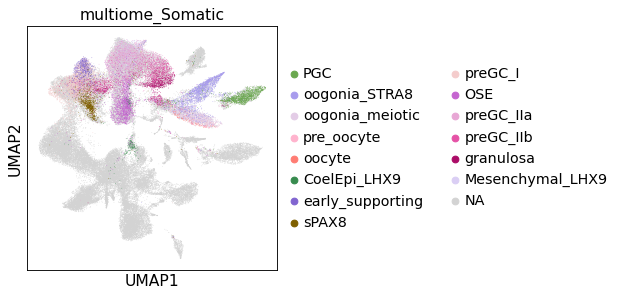

In [42]:
sc.pl.umap(adata, color = 'multiome_Somatic', 
          groups = ['PGC', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_oocyte', 'oocyte', 'CoelEpi_LHX9', 'early_supporting', 'sPAX8', 'preGC_I', 'OSE', 
                                                                                     'preGC_IIa', 'preGC_IIb', 'granulosa', 'Mesenchymal_LHX9'],
           palette = ['#6aa84f', '#a89ced', '#e3cce6', '#ffb3cd', '#ff7c73','#378b4e', '#8165d0', '#7f6000', '#f4cccc', '#c565d0', '#e8a7d5', '#e552a6', '#ab0c67', '#dacef4'],
          save = '_multiome_all')

#### Import somatic annotations

In [29]:
import pandas as pd 
somatic_annotations = pd.read_csv('/nfs/team292/vl6/my_MULTIOME_dir/supporting_july2021/supporting_annotations.csv', index_col = 0)
somatic_annotations.head()

/opt/conda/envs/atac_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


cellatac_clusters  n_genes_by_counts  \
01-AAACAGCCACTAGCGT-1                  9                210   
01-AAACCGGCAACCCTCC-1                  9                368   
01-AAACCGGCAAGTAAGC-1                  9                182   
01-AAACGGATCCGCCAAA-1                  9               2472   
01-AAACGTACAGGTTATT-1                  8                479   

                       log1p_n_genes_by_counts  total_counts  \
01-AAACAGCCACTAGCGT-1                 5.351858         210.0   
01-AAACCGGCAACCCTCC-1                 5.910797         368.0   
01-AAACCGGCAAGTAAGC-1                 5.209486         182.0   
01-AAACGGATCCGCCAAA-1                 7.813187        2472.0   
01-AAACGTACAGGTTATT-1                 6.173786         479.0   

                       log1p_total_counts  pct_counts_in_top_50_genes  \
01-AAACAGCCACTAGCGT-1            5.351858                   23.809524   
01-AAACCGGCAACCCTCC-1            5.910797                   13.586957   
01-AAACCGGCAAGTAAGC-1            5.209486                   27.472527   
01-AAACGGATCCGCCAAA-1            7.813187                    2.022654   
01-AAACGTACAGGTTATT-1            6.173786                   10.438413   

                       pct_counts_in_top_100_genes  \
01-AAACAGCCACTAGCGT-1                    47.619048   
01-AAACCGGCAACCCTCC-1                    27.173913   
01-AAACCGGCAAGTAAGC-1                    54.945055   
01-AAACGGATCCGCCAAA-1                     4.045307   
01-AAACGTACAGGTTATT-1                    20.876827   

                       pct_counts_in_top_200_genes  \
01-AAACAGCCACTAGCGT-1                    95.238095   
01-AAACCGGCAACCCTCC-1                    54.347826   
01-AAACCGGCAAGTAAGC-1                   100.000000   
01-AAACGGATCCGCCAAA-1                     8.090615   
01-AAACGTACAGGTTATT-1                    41.753653   

                       pct_counts_in_top_500_genes multiome_Somatic  ...  \
01-AAACAGCCACTAGCGT-1                   100.000000        preGC_IIb  ...   
01-AAACCGGCAACCCTCC-1                   100.000000        granulosa  ...   
01-AAACCGGCAAGTAAGC-1                   100.000000        granulosa  ...   
01-AAACGGATCCGCCAAA-1                    20.226537        preGC_IIb  ...   
01-AAACGTACAGGTTATT-1                   100.000000        preGC_IIa  ...   

                       early_somatic CoelEpi_GATA2 late_sPAX8 granulosa  \
01-AAACAGCCACTAGCGT-1            0.0           0.0        0.0  0.240985   
01-AAACCGGCAACCCTCC-1            0.0           0.0        0.0  0.084440   
01-AAACCGGCAAGTAAGC-1            0.0           0.0        0.0  0.000000   
01-AAACGGATCCGCCAAA-1            0.0           0.0        0.0  0.000000   
01-AAACGTACAGGTTATT-1            0.0           0.0        0.0  0.032612   

                            max  leiden_R  leiden_2  leiden_3  stage_numeric  \
01-AAACAGCCACTAGCGT-1  0.397496         0         0         0           21.0   
01-AAACCGGCAACCCTCC-1  0.869140         3         3         3           21.0   
01-AAACCGGCAAGTAAGC-1  0.888004         3         3         3           21.0   
01-AAACGGATCCGCCAAA-1  0.892645         6         6         6           21.0   
01-AAACGTACAGGTTATT-1  0.874909         3         3         3           21.0   

                              cell_type  
01-AAACAGCCACTAGCGT-1           Sertoli  
01-AAACCGGCAACCCTCC-1  early_supporting  
01-AAACCGGCAAGTAAGC-1  early_supporting  
01-AAACGGATCCGCCAAA-1               OSE  
01-AAACGTACAGGTTATT-1  early_supporting  

[5 rows x 40 columns]

In [30]:
somatic_annotations = somatic_annotations[somatic_annotations['sex'] == 'female']

In [31]:
somatic_annotations['cell_type'].value_counts()

preGC_IIa           8369
preGC_I             6567
early_supporting    5787
preGC_IIb           5721
Oi                  4852
OSE                 4728
Gi                  3639
sPAX8               1445
granulosa           1177
CoelEpi_LHX9         908
Ti                   325
Sertoli               75
CoelEpi_GATA2         39
FetalLeydig           11
Name: cell_type, dtype: int64

In [32]:
somatic_annotations = somatic_annotations[somatic_annotations['cell_type'].isin(['granulosa', 'preGC_IIb', 'preGC_IIa', 'OSE', 'preGC_I', 
                                                            'CoelEpi_GATA2', 'CoelEpi_LHX9', 'early_supporting', 'Oi', 'sPAX8', 'Gi'])]

In [33]:
somatic_annotations['matching_barcode'] = [i[3:] for i in somatic_annotations.index.to_list()]

In [34]:
somatic_annotations['matching_barcode'] = somatic_annotations['sample'].astype(str) + '_' + somatic_annotations['matching_barcode'].astype(str)

In [35]:
adata.obs['matching_barcode'] = [i[3:] for i in adata.obs_names.to_list()]

In [36]:
adata.obs['matching_barcode'] = adata.obs['sample'].astype(str) + '_' + adata.obs['matching_barcode'].astype(str)

In [37]:
somatic_annotations = somatic_annotations.set_index('matching_barcode')

In [38]:
adata.obs['somatic_annotation'] = adata.obs['matching_barcode'].map(somatic_annotations['cell_type'].to_dict())

In [43]:
adata.obs['somatic_annotation'] = adata.obs['somatic_annotation'].fillna(adata.obs['cell_type'])

In [44]:
adata.obs['somatic_annotation'].value_counts(dropna = False)

Mesenchymal_GATA2    18408
GermCells             9496
preGC_IIa             8369
preGC_I               6567
early_supporting      5787
preGC_IIb             5721
PV                    5589
Oi                    4852
OSE                   4728
Gi                    3639
Endothelial           3107
Epithelial            1801
sPAX8                 1445
granulosa             1177
Supporting            1107
Immune                1069
SMCs                   966
Neural                 963
CoelEpi_LHX9           908
preGranulosa           864
Mesenchymal_LHX9       493
CoelEpi                116
CoelEpi_GATA2           39
Name: somatic_annotation, dtype: int64

In [45]:
adata = adata[[i not in ['preGranulosa', 'Supporting', 'Mesenchymal_LHX9', 'CoelEpi'] for i in adata.obs['somatic_annotation']]]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [46]:
female_colors_somatic = {'GermCells': '#e69429',
 'CoelEpi_LHX9' : '#378b4e', 'CoelEpi_GATA2' : '#79bd5e', 'Gi' : '#d8d1ff', 'Oi' : '#ff7c73',
    'preGC_I' : '#f4cccc', 'preGC_IIa' : '#e8a7d5', 'preGC_IIb' : '#e552a6', 'granulosa' : '#ab0c67', 'sPAX8' : '#7f6000', 'OSE' : '#c565d0', 'early_supporting' : '#8165d0',
 'Mesenchymal_GATA2': '#fbbc04',
 'PV': '#d4b16c',
 'SMCs': '#daed3e',
 'Immune': '#039eaa',
 'Endothelial': '#efd6bb',
 'Epithelial': '#b4b90e',
 'Neural': '#ffde00'}
adata.uns['somatic_colors'] = female_colors_somatic

Trying to set attribute `.uns` of view, copying.


... storing 'somatic_annotation' as categorical


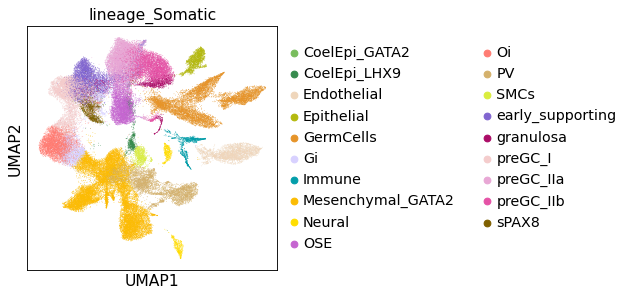

In [47]:
sc.pl.umap(adata, color = 'somatic_annotation', palette = female_colors_somatic, title = 'lineage_Somatic', 
          save = '_lineage_somatic')

In [48]:
adata.shape

(84631, 153356)

In [10]:
adata.write(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")

NameError: name 'adata' is not defined

In [101]:
adata.obs['multiome_GermCells'].value_counts()

nan                81811
oogonia_STRA8       2118
PGC                 1439
oogonia_meiotic     1141
preOocyte            297
Doublet              163
oocyte               157
lowQC                 85
Name: multiome_GermCells, dtype: int64

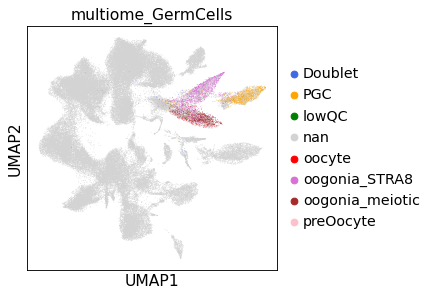

In [102]:
sc.pl.umap(adata, color = 'multiome_GermCells', save = '_multiome_GermCells')

In [103]:
adata.obs['multiome_Somatic'].value_counts()

nan                 72074
preGC_I              3131
preGC_IIa            2982
preGC_IIb            1898
OSE                  1245
granulosa            1176
early_sPAX8          1134
early_supporting     1064
Mesenchymal_LHX9     1000
OSE_cycling           619
lowQC                 347
CoelEpi_LHX9          280
Doublet               261
Name: multiome_Somatic, dtype: int64

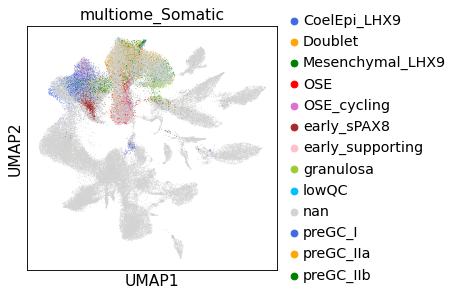

In [104]:
sc.pl.umap(adata, color = 'multiome_Somatic', save = '_multiome_Somatic')

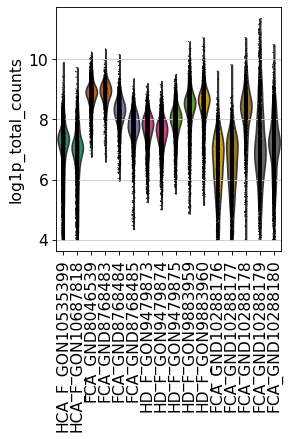

In [105]:
sc.pl.violin(adata, keys = ['log1p_total_counts'], groupby = 'sample', rotation = 90, 
            save = '_seqdepth')

#### Select female germ cells

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


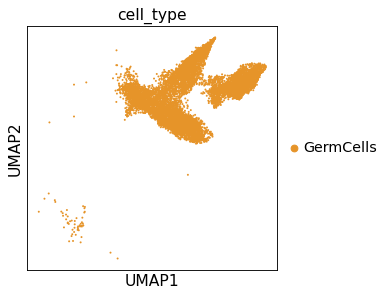

In [55]:
germ = adata[[i in ['GermCells'] for i in adata.obs['cell_type']]]
sc.pl.umap(germ, color = 'cell_type')

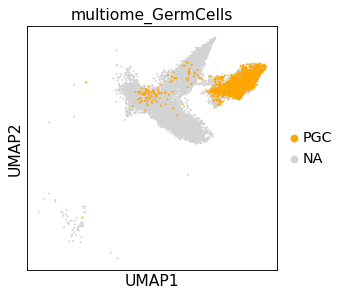

In [62]:
sc.pl.umap(germ, color = ['multiome_GermCells'], groups = 'PGC')

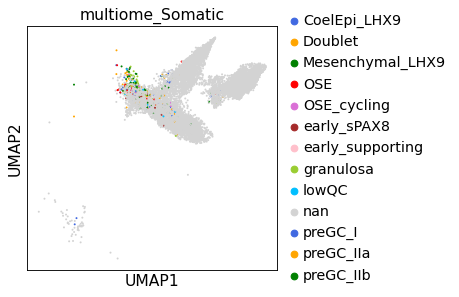

In [64]:
sc.pl.umap(germ, color = ['multiome_Somatic'])

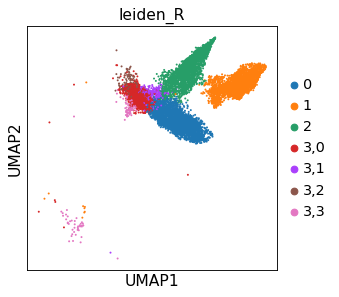

In [72]:
sc.tl.leiden(germ, resolution = 0.2)
sc.tl.leiden(germ, resolution = 0.3, restrict_to = ('leiden', ['3']))
sc.pl.umap(germ, color = 'leiden_R')

In [77]:
germ = germ[[i not in ['3,2', '3,3'] for i in germ.obs['leiden_R']]]
germ.shape

(9036, 153356)

In [78]:
germ.obs['multiome_GermCells'].value_counts()

nan                3913
oogonia_STRA8      2109
PGC                1427
oogonia_meiotic    1136
preOocyte           294
oocyte              157
Name: multiome_GermCells, dtype: int64

In [79]:
germ = germ[[i not in ['lowQC', 'Doublet'] for i in germ.obs['multiome_GermCells']]]
germ.shape

(9036, 153356)

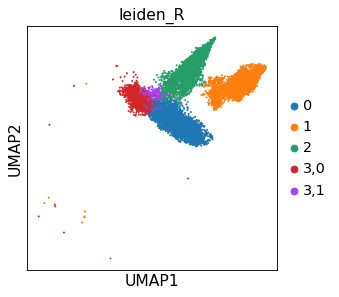

In [80]:
sc.pl.umap(germ, color = 'leiden_R')

In [81]:
germ.obs[['sample', 'code', 'cell_type']].to_csv(outdir + experiment_prefix + '_germ_barcodes.csv')

#### Select gonadal somatic cells

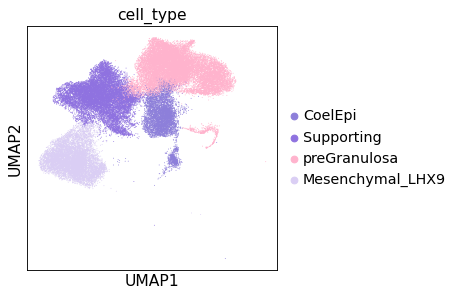

In [130]:
somatic_celltype = ['CoelEpi', 'Mesenchymal_LHX9', 'Supporting', 'preGranulosa']
somatic = adata[[i in somatic_celltype for i in adata.obs['cell_type']]]
sc.pl.umap(somatic, color = 'cell_type')

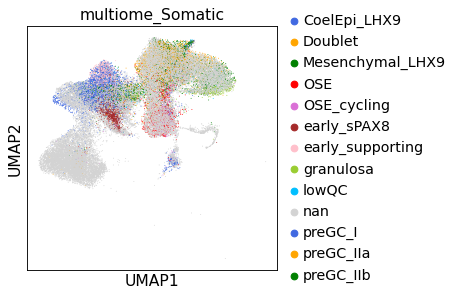

In [131]:
sc.pl.umap(somatic, color = ['multiome_Somatic'])

In [132]:
somatic = somatic[[i not in ['lowQC', 'Doublet'] for i in somatic.obs['multiome_Somatic']]]
somatic.shape

(45290, 153356)

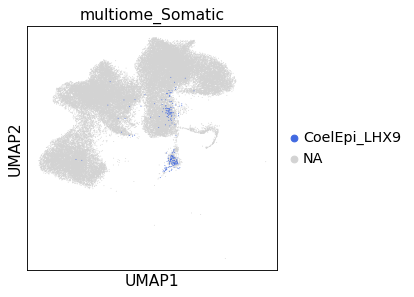

In [133]:
sc.pl.umap(somatic, color = ['multiome_Somatic'], groups = 'CoelEpi_LHX9')

In [134]:
somatic.obs[['sample', 'code', 'cell_type']].to_csv(outdir + experiment_prefix + '_somatic_barcodes.csv')

#### End of notebook